In [1]:
import scniche as sn
import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/scniche_v101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.1.1


In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/50249673)
# adata = sn.datasets.human_dlpfc_visium()
adata = sc.read('DLPFC_donor3.h5ad')
adata

AnnData object with n_obs × n_vars = 14243 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'domain', 'slice'
    uns: 'CN_order'
    obsm: 'X_C2L', 'X_scVI', 'spatial'

In [3]:
# Deconvoluted results by Cell2Location
decon_res = pd.DataFrame(adata.obsm['X_C2L'].copy(), index=adata.obs_names)
decon_res.columns = adata.uns['CN_order']
decon_res

,Astro L1-2 FGFR3 GFAP,Astro L1-6 FGFR3 SLC14A1,Endo L2-6 NOSTRIN,Exc L2 LAMP5 LTK,Exc L2-3 LINC00507 FREM3,Exc L2-4 LINC00507 GLP2R,Exc L3-4 RORB CARM1P1,Exc L3-5 RORB COL22A1,Exc L3-5 RORB ESR1,Exc L3-5 RORB FILIP1L,...,Inh L4-6 SST GXYLT2,Inh L5-6 GAD1 GLP1R,Inh L5-6 PVALB LGR5,Inh L5-6 SST KLHDC8A,Inh L5-6 SST MIR548F2,Inh L5-6 SST NPM1P10,Inh L5-6 SST TH,Micro L1-3 TYROBP,OPC L1-6 PDGFRA,Oligo L1-6 OPALIN
CGGAACGTAAACATAG-1-151673,0.145071,0.003062,0.012808,0.001260,0.000312,0.000377,0.000056,0.002092,0.000352,0.000086,...,0.000279,0.000100,0.000136,0.000071,0.000095,0.000186,0.000102,0.087921,0.021528,0.502758
AGACCGCTCCGCGGTT-1-151673,0.077005,0.082502,0.007804,0.222518,0.061411,0.049911,0.009740,0.032107,0.018604,0.009531,...,0.002771,0.003318,0.002392,0.003695,0.001689,0.004897,0.010220,0.052601,0.008998,0.021663
GTAACATCTAAGATAA-1-151673,0.044665,0.082132,0.010922,0.202151,0.094374,0.034700,0.011407,0.025713,0.014282,0.012807,...,0.002768,0.002631,0.001656,0.006553,0.002296,0.004912,0.008516,0.020145,0.028424,0.016516
TAACCTAGGGAGTCCA-1-151673,0.031793,0.056906,0.020973,0.120073,0.104925,0.039159,0.014734,0.022230,0.020036,0.013496,...,0.003401,0.004729,0.002420,0.009820,0.002767,0.004689,0.016823,0.028891,0.016759,0.006947
GGGTCAGGAGCTAGAT-1-151673,0.146884,0.027044,0.024385,0.028301,0.010719,0.015855,0.003887,0.031334,0.012741,0.004345,...,0.002831,0.001664,0.001212,0.001534,0.001220,0.003776,0.006694,0.054145,0.017173,0.154429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTTTCAATGAAGAAA-1-151676,0.073446,0.059160,0.012873,0.021815,0.011625,0.015095,0.008339,0.123450,0.033011,0.010364,...,0.002621,0.004736,0.005009,0.002853,0.003662,0.005995,0.011410,0.041444,0.018156,0.032667
GCCGACCCACGACTGC-1-151676,0.081011,0.000292,0.018221,0.000089,0.000016,0.000033,0.000007,0.000890,0.000034,0.000008,...,0.000094,0.000037,0.000073,0.000068,0.000037,0.000074,0.000028,0.083527,0.017141,0.633062
TCGCTCGATATATTCC-1-151676,0.068238,0.031611,0.008849,0.022456,0.010568,0.022125,0.007097,0.073096,0.029430,0.008475,...,0.002600,0.004597,0.004013,0.002912,0.002873,0.007144,0.017888,0.019263,0.003671,0.032389
CAGATCCTGGTTTGAA-1-151676,0.199356,0.002378,0.022828,0.000440,0.000072,0.000158,0.000037,0.002145,0.000124,0.000042,...,0.000296,0.000156,0.000263,0.000130,0.000127,0.000215,0.000076,0.092625,0.029164,0.510034


In [4]:
celltype_key='domain' # not use, just for `sn.pp.process_multi_slices`
sample_key = 'slice'
use_rep = 'X_scVI'
k_cutoff = 6
lr = 0.01
epochs = 100
batch_num = 2


# prepare multi slices
adata = sn.pp.process_multi_slices(
    adata=adata,
    celltype_key=celltype_key,
    sample_key=sample_key,
    mode='KNN',
    k_cutoff=k_cutoff,
    is_pca=False,
    verbose=False,
    layer_key=use_rep
)

# choose the features of the three views `X_C2L`, `X_data`, and `X_data_nbr` to run scNiche     
choose_views = ['X_C2L', 'X_data', 'X_data_nbr']
adata = sn.pp.prepare_data_batch(adata=adata, verbose=False, batch_num=batch_num, choose_views=choose_views)

# training
model = sn.tr.Runner_batch(adata=adata, device='cuda:0', verbose=False, choose_views=choose_views)
adata = model.fit(lr=0.01, epochs=epochs)

# clustering
target_num = len(set(adata.obs['domain']))
adata = sn.tr.clustering(adata=adata, target_k=target_num)

-------Process 4 slices...


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Applying K-Means Clustering with 7 target cluster numbers...


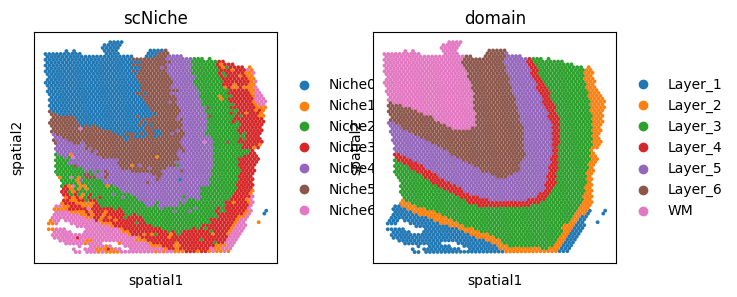

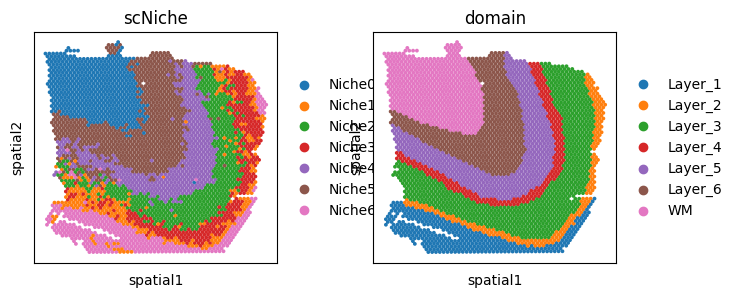

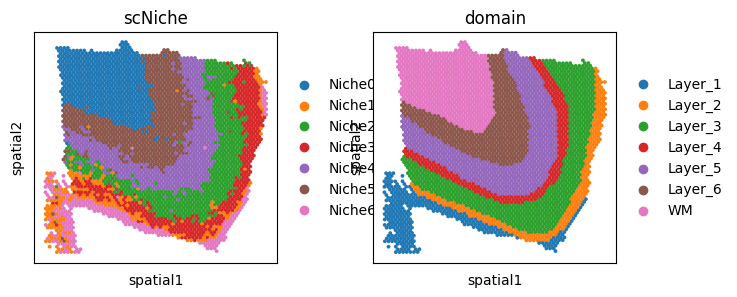

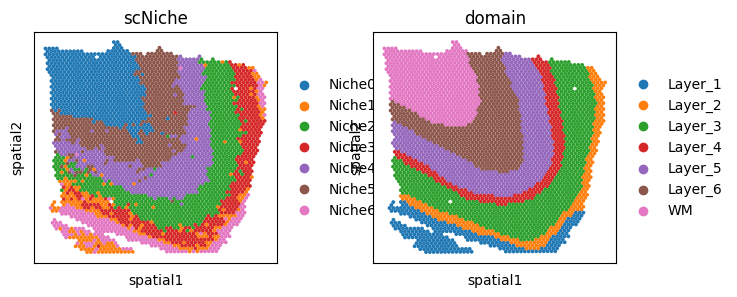

In [5]:
for i in ['151673', '151674', '151675', '151676']:
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.embedding(adata[adata.obs['slice'] == 'slice' + i], basis="spatial", color=['scNiche', 'domain'],s=30, )

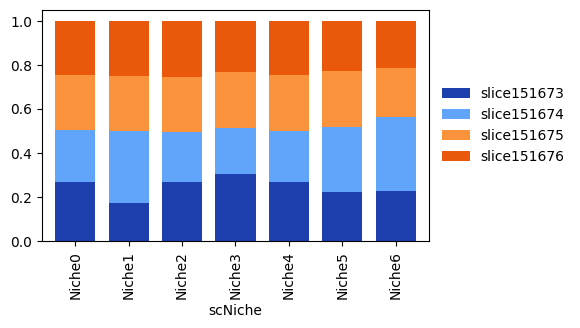

In [6]:
kwargs = {'figsize': (5, 3)}
palette_use = ["#1e40af", "#60a5fa", "#fb923c", "#ea580c"]
sn.pl.stacked_barplot(adata, x_axis='scNiche', y_axis='slice', mode='proportion', palette=palette_use, kwargs=kwargs)

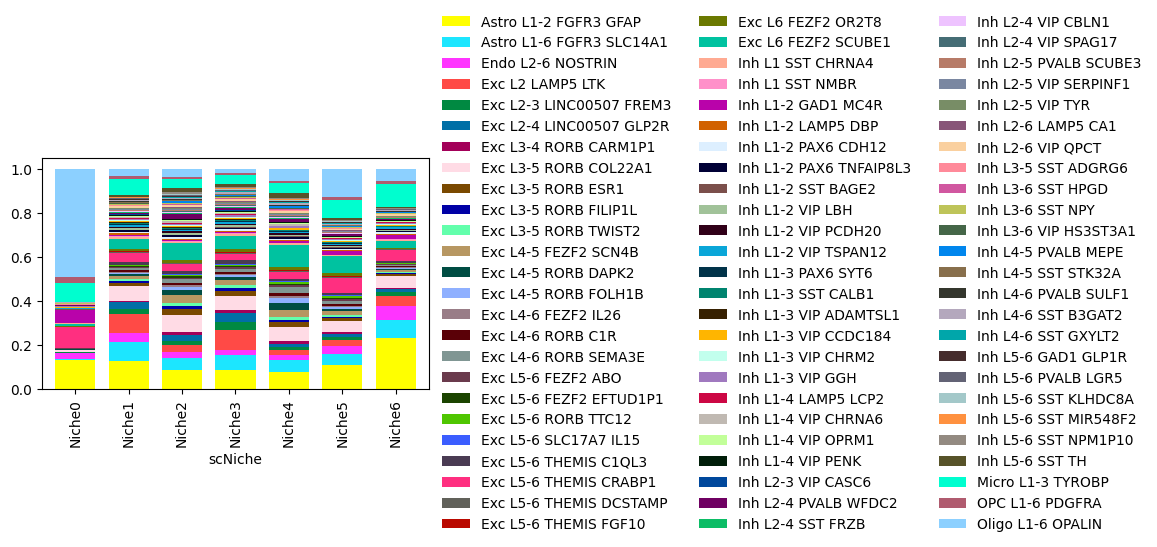

In [7]:
kwargs = {'figsize': (5, 3)}
sn.pl.stacked_barplot_spot(adata, x_axis='scNiche', y_axis='X_C2L', y_axis_labels=decon_res.columns, palette=sn.pl.palettes.default_102, kwargs=kwargs)

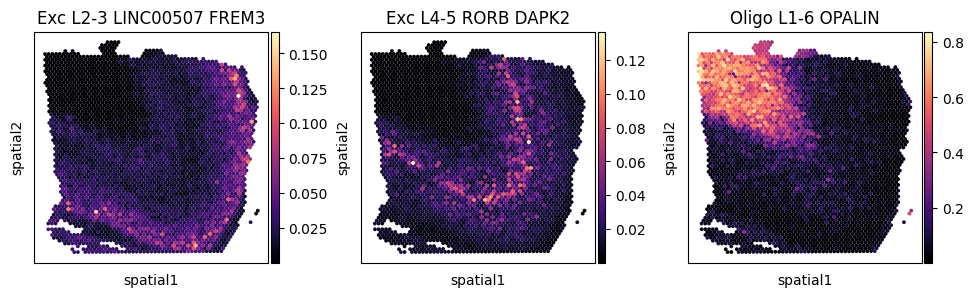

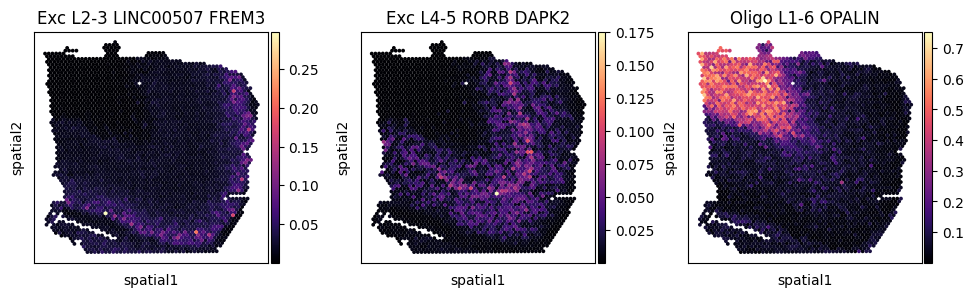

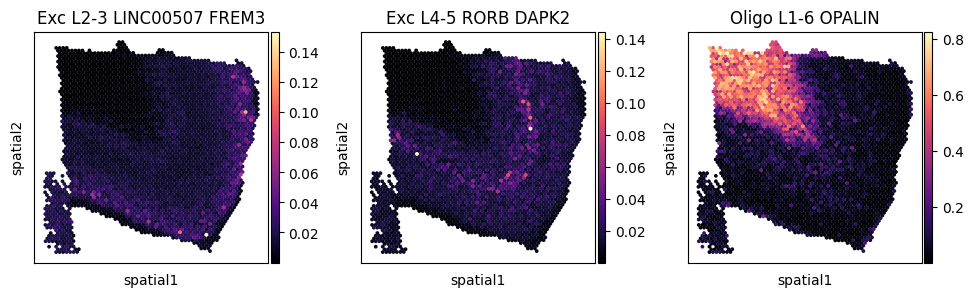

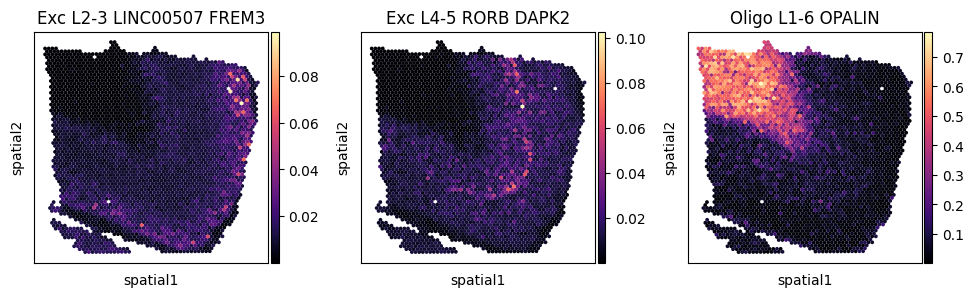

In [8]:
show_celltype = ['Exc L2-3 LINC00507 FREM3', 'Exc L4-5 RORB DAPK2', 'Oligo L1-6 OPALIN']
for ct in show_celltype:
    adata.obs[ct] = decon_res[ct].values

for i in ['151673', '151674', '151675', '151676']:
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.embedding(adata[adata.obs['slice'] == 'slice' + i], basis="spatial", color=show_celltype, s=30, cmap='magma')

In [9]:
# enrichment analysis
sn.al.enrichment_spot(adata=adata, deconvoluted_res=decon_res, val_key='scNiche', library_key='slice')

Calculating the enrichment of each deconvoluted cluster in group (scNiche)...


Cluster: Oligo L1-6 OPALIN: 100%|██████████| 7/7 [00:00<00:00, 357.77it/s]


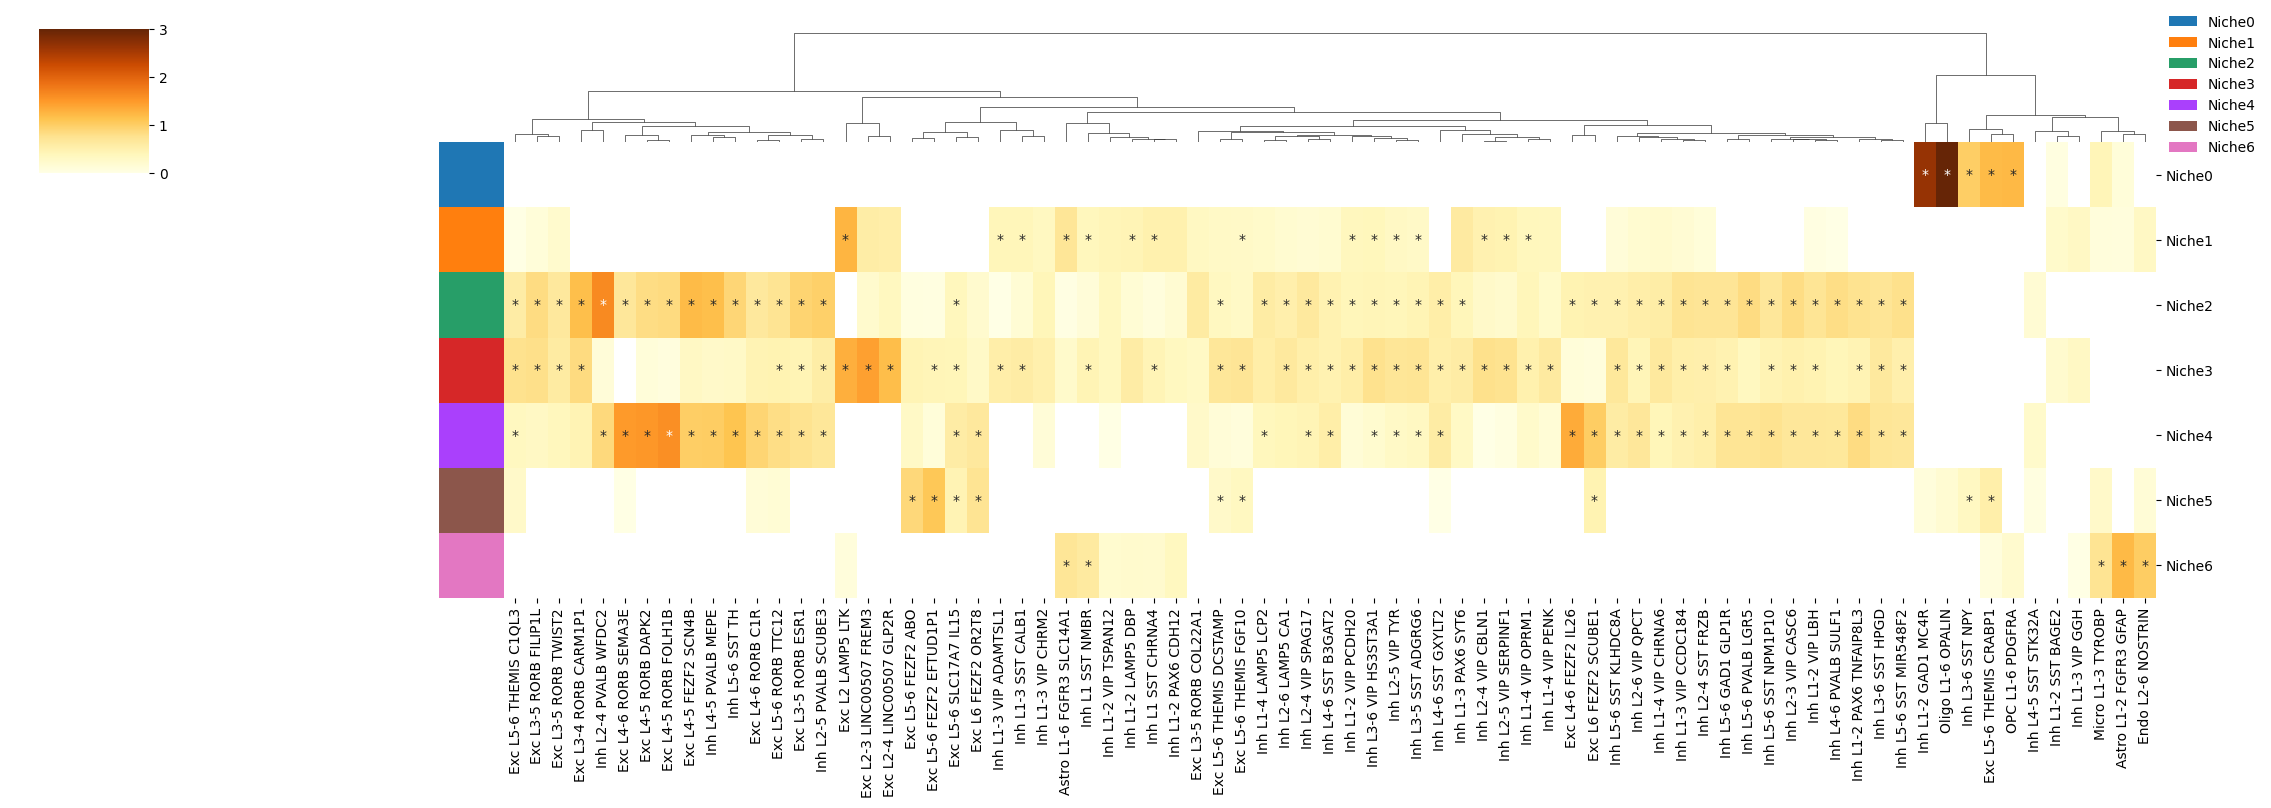

In [10]:
# plot, id_key='celltype'
kwargs = {'figsize': (22, 8), 'vmax': 3, 'cmap': 'YlOrBr', 'linewidths': 0, 'linecolor': 'white', }
row_order =[ 'Niche0', 'Niche1', 'Niche2', 'Niche3', 'Niche4', 'Niche5', 'Niche6', ]
sn.pl.enrichment_heatmap(
    adata=adata, 
    id_key='celltype', 
    val_key='scNiche', 
    binarized=False, 
    show_pval=True,
    row_order=row_order, 
    kwargs=kwargs)